In [2]:
import math
import torch
import gpytorch
import botorch
import gc
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, CNN
from IPython.display import display, clear_output

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.manual_seed(40)
np.random.seed(40)

In [4]:
def clear_model():
    # Clear as much 'stuff' as possible
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    %reload_ext autoreload

In [5]:
def sinc(x):
    return torch.sin(math.pi * x) / (math.pi * x)

def objective(x):
    return sinc(x+10) + sinc(x) + sinc(x-10)

pts = 1000
X = torch.linspace(-15,15,pts) # value locations
y = objective(X) # objective function

train_x = X[torch.logical_or(X<=-4.5, X>=4.5)] # value locations we know
train_y = objective(train_x)
# test_x = X[torch.logical_and(X>-4.5, X<4.5)] # value locations we don't know (to predict)
test_x = torch.linspace(-4.5,4.5,100)

trueMeansInit = torch.tensor([[[.03]], [[.1]], [[.2]], [[.3]], [[.415]], [[.424]], [[.492]]])
Q = 7

In [355]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=Q)
#         self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=Q, mixture_means_constraint=None, mixture_scales_constraint=None, mixture_weights_constraint=None)
#         self.covar_module.initialize_from_data_empspect(train_x, train_y)
        self.covar_module.initialize_from_data(train_x, train_y)
#             [0.03; 0.1; 0.2; 0.3; 0.415; 0.424; 0.492] means
#             0.05 for scales
        # weights @ 1
#         self.covar_module.mixture_weights = wInit
#         self.covar_module.mixture_means = mInit
#         self.covar_module.mixture_scales = sInit

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [360]:
def train(parameterization, final=False, train_iters=100, seed=40):
#     wInit = torch.ones(Q) * parameterization.get('weights')
#     mInit = torch.ones(Q) * parameterization.get('means')
#     sInit = (torch.ones(Q) * parameterization.get('scales')).reshape((Q,1,1))
#     wInit = torch.tensor([0.0126, 0.0146, 0.0113, 0.0193, 0.0315, 0.0073, 0.0039])
    mInit = [.003, .1, .2, .3, .415, .424, .492]
    wInit = [.001 for _ in range(Q)]
    sInit = [.001 for _ in range(Q)]
#     wInit = torch.ones(7) / 7
#     if parameterization.get('squareWeights') == 1:
#         wInit = torch.square(wInit)
#     elif parameterization.get('squareWeights') == 2:
#         wInit = torch.sqrt(wInit)
#     mInit = torch.tensor([[[.03]], [[.1]], [[.2]], [[.3]], [[.415]], [[.424]], [[.492]]])
#     mInit = torch.ones(7) * .5
#     sInit = torch.tensor([[[0.0650]],

#         [[0.0680]],

#         [[0.0372]],

#         [[0.0158]],

#         [[0.0057]],

#         [[0.0022]],

#         [[0.0002]]])
#     sInit = torch.ones(7)*.05
    torch.manual_seed(seed)
    
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-6)).cuda()
#     likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = SpectralMixtureGPModel(train_x, train_y, likelihood).cuda()
#     print(model)
#     [print(f'{p[0]}: {p[1].data}') for p in model.named_parameters()]
#     print(model.covar_module.mixture_means)
#     model.covar_module.raw_mixture_means = torch.nn.Parameter(torch.log(torch.tensor(mInit)).reshape((Q,1,1)))
#     model.covar_module.raw_mixture_weights = torch.nn.Parameter(torch.log(torch.tensor(wInit)))
#     model.covar_module.raw_mixture_scales = torch.nn.Parameter(torch.log(torch.tensor(sInit)).reshape((Q,1,1)))
#     model.covar_module.mixture_means = mInit
#     model.covar_module.mixture_weights = [0.1262, 0.1380, 0.1191, 0.1209, 0.1330, 0.1311, 0.1101]
#     model.covar_module.mixture_scales = [0.0565,0.0458,0.0512,0.0521,0.0351, 0.0329,0.0178]
#     model.likelihood.noise_covar.noise = [4.6132e-06]
#     model.covar_module.mixture_weights = [0.0012446, 0.0011744, 0.0012237, 0.0012022, 0.0011678, 0.0011675, 0.0012101]
#     model.covar_module.mixture_means = [0.01924, 0.094706, 0.19714, 0.30178, 0.39105, 0.4376, 0.48875]
#     model.covar_module.mixture_scales = [0.0041844, 0.0035327, 0.0037169, 0.0037729, 0.0037552, 0.0037752, 0.0048876]
#     model.covar_module.mixture_weights = wInit
    model.covar_module.mixture_means = mInit
#     model.covar_module.mixture_scales = sInit
    model.likelihood.noise = .0001
#     [print(f'{p[0]}: {p[1].data}') for p in model.named_parameters()]
#     print(model.covar_module.mixture_means)
#     model.likelihood.covar_noise = torch.tensor([0.0001])
#     model.likelihood.noise_covar.raw_noise = torch.nn.Parameter(torch.tensor([-13.5248]))
#     model.covar_module.raw_mixture_means = torch.nn.Parameter(torch.tensor([[[-3.4858]],

#         [[-1.6472]],

#         [[-0.6187]],

#         [[-1.0523]],

#         [[-1.4259]],

#         [[-1.3785]],

#         [[-3.8345]]]))
#     model.covar_module.raw_mixture_means = torch.nn.Parameter(torch.log(torch.tensor([.03, .1, .2, .3, .415, .424, .492])).reshape((Q,1,1)))
#     model.covar_module.raw_mixture_scales = torch.nn.Parameter(torch.log(torch.ones(Q) * .05).reshape(Q,1,1))
#     model.covar_module.raw_mixture_weights = torch.nn.Parameter(torch.log(torch.ones(Q) / Q))
#     model.covar_module.raw_mixture_scales = torch.nn.Parameter(torch.tensor([[[-2.7544]],

#         [[-2.6836]],

#         [[-3.4353]],

#         [[-4.3303]],

#         [[-5.0044]],

#         [[-6.0534]],

#         [[-8.5946]]]))
#     model.covar_module.raw_mixture_weights = torch.nn.Parameter(torch.tensor([-4.3235, -4.1980, -4.6122, -3.9938, -3.5326, -5.0431, -5.5464]))
    model.train()
    likelihood.train()
#     optimizer = torch.optim.SGD([model.likelihood.noise_covar.raw_noise, model.covar_module.raw_mixture_weights, model.covar_module.raw_mixture_scales],
#                                 lr=parameterization.get('lr'), momentum=parameterization.get('momentum'), weight_decay=parameterization.get('weight_decay'))
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, 1.5)
#     optimizer = torch.optim.LBFGS([model.likelihood.noise_covar.raw_noise, model.covar_module.raw_mixture_weights, model.covar_module.raw_mixture_scales], lr=parameterization.get('lr'))
    optimizer = torch.optim.SGD([p[1] for p in model.named_parameters() if p[0] not in ['covar_module.raw_mixture_means','covar_module.raw_mixture_weights']], lr=.045, momentum=.6, weight_decay=1e-4)
    trainParams = [
        model.covar_module.raw_mixture_weights,
        model.covar_module.raw_mixture_means,
        model.covar_module.raw_mixture_scales
    ]
#     optimizer = torch.optim.SGD([model.likelihood.noise_covar.raw_noise], lr=.1)
#     optimizer = torch.optim.Adam(trainParams, lr=.5)
    optimizer = torch.optim.Adam(trainParams,lr=.005)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    print(f'INIT MLL: {-mll(model(train_x),train_y).item()}')
#     [print(p) for p in model.named_parameters()]
    modelLoss = 0
#     with gpytorch.settings.max_cholesky_size(0), gpytorch.settings.max_cg_iterations(5000):
#         for i in range(train_iters):
#     #         clear_output(wait=True) # for outputting training progress
#             optimizer.zero_grad() # Clears the gradients of all optimized tensors
#             output = model(train_x)
#             loss = -mll(output, train_y)
#             loss.backward()
#             if (((i+1) % 10)==0): print('Iter %d/%d - Loss: %.3f' % (i + 1, train_iters, loss.item()))
#             optimizer.step()    
#             modelLoss = loss.item()
    
    with gpytorch.settings.max_cholesky_size(0), gpytorch.settings.max_cg_iterations(10000):
        for i in range(train_iters):
            def closure():
    #             model.train()
    #             clear_output(wait=True)
                optimizer.zero_grad()
                output = model(train_x)
                loss = -mll(output, train_y)
                loss.backward()
                print('Iter %d/%d - Loss: %.3f' % (i + 1, train_iters, loss.item()))
    #             if (((i+1) % 50)==0): print('Iter %d/%d - Loss: %.3f' % (i + 1, train_iters, loss.item()))
                modelLoss = loss.item()
    #             evaluate(model, likelihood)
                return loss
    #         print(f'{i+1}/{train_iters}: {modelLoss}')
            optimizer.step(closure)
# # #             scheduler.step()
#     model.covar_module.mixture_means = mInit
    
    if not final:
        return -modelLoss
    return model, likelihood

def evaluate(model, likelihood):
    model.eval()
    likelihood.eval()
    
    with torch.no_grad(), gpytorch.settings.max_cholesky_size(0):
        # Make predictions
        observed_pred = likelihood(model(test_x))

        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(12, 9))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
    return observed_pred

def wrapper(parameterization):
    res = train(parameterization)
#     print(f'mll: {-res}')
    return res

In [536]:
parameters_to_optimize = [
    {"name": "lr", "type": "range", "bounds": [1e-6, 1], "value_type": "float", "log_scale": True},
#     {"name": "momentum", "type": "range", "bounds": [1e-6, 1], "value_type": "float"},
#     {"name": "weight_decay", "type": "range", "bounds": [1e-6, .3], "value_type": "float"},
#     {"name": "squareWeights", "type": "choice", "values": [0, 1, 2]}
]

best_parameters, values, experiment, out_model = optimize(
    parameters=parameters_to_optimize,
    evaluation_function=wrapper,
    objective_name='mll'
)

[INFO 12-04 15:56:20] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 12-04 15:56:20] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 12-04 15:56:20] ax.service.managed_loop: Running optimization trial 1...


INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 1/100 - Loss: -3.466
Iter 1/100 - Loss: -3.453
Iter 1/100 - Loss: -3.464
Iter 1/100 - Loss: -3.429
Iter 1/100 - Loss: -3.448
Iter 1/100 - Loss: -3.503
Iter 1/100 - Loss: -3.461
Iter 1/100 - Loss: -3.456
Iter 1/100 - Loss: -3.472
Iter 1/100 - Loss: -3.428
Iter 1/100 - Loss: -3.495
Iter 1/100 - Loss: -3.443
Iter 1/100 - Loss: -3.441
Iter 1/100 - Loss: -3.454
Iter 1/100 - Loss: -3.470
Iter 1/100 - Loss: -3.448
Iter 1/100 - Loss: -3.494
Iter 2/100 - Loss: -3.470
Iter 2/100 - Loss: -3.456
Iter 2/100 - Loss: -3.470
Iter 2/100 - Loss: -3.473
Iter 2/100 - Loss: -3.454
Iter 2/100 - Loss: -3.452
Iter 2/100 - Loss: -3.466
Iter 2/100 - Loss: -3.465
Iter 2/100 - Loss: -3.439
Iter 2/100 - Loss: -3.448
Iter 2/100 - Loss: -3.482
Iter 2/100 - Loss: -3.485
Iter 2/100 - Loss: -3.460
Iter 2/100 - Loss: -3.421
Iter 2/100 - Loss: -3.458
Iter 2/100 - Loss: -3.441
Iter 2/100 - Loss: -3.459
Iter 2/1

[INFO 12-04 15:56:36] ax.service.managed_loop: Running optimization trial 2...


Iter 99/100 - Loss: -3.469
Iter 100/100 - Loss: -3.468
INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.478
Iter 1/100 - Loss: -3.487
Iter 1/100 - Loss: -3.465
Iter 1/100 - Loss: -3.453
Iter 1/100 - Loss: -3.462
Iter 1/100 - Loss: -3.428
Iter 2/100 - Loss: -3.448
Iter 3/100 - Loss: -3.502
Iter 4/100 - Loss: -3.461
Iter 4/100 - Loss: -3.454
Iter 5/100 - Loss: -3.471
Iter 6/100 - Loss: -3.426
Iter 7/100 - Loss: -3.492
Iter 8/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 9/100 - Loss: -3.453
Iter 10/100 - Loss: -3.472
Iter 11/100 - Loss: -3.446
Iter 12/100 - Loss: -3.492
Iter 13/100 - Loss: -3.470
Iter 13/100 - Loss: -3.456
Iter 14/100 - Loss: -3.471
Iter 14/100 - Loss: -3.473
Iter 15/100 - Loss: -3.458
Iter 16/100 - Loss: -3.455
Iter 16/100 - Loss: -3.467
Iter 17/100 - Loss: -3.466
Iter 17/100 - Loss: -3.442
Iter 18/100 - Loss: -3.451
Iter 18/100 - Loss: -3.487
Iter 19/100 - Loss: -3.487
Iter 20/100 - Loss: -3.460
Iter 21/100 - Loss: -3.424
Iter 21/100 - 

[INFO 12-04 15:56:41] ax.service.managed_loop: Running optimization trial 3...


Iter 96/100 - Loss: -3.447
Iter 96/100 - Loss: -3.456
Iter 97/100 - Loss: -3.459
Iter 98/100 - Loss: -3.476
Iter 99/100 - Loss: -3.481
Iter 100/100 - Loss: -3.465
INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.486
Iter 2/100 - Loss: -3.464
Iter 3/100 - Loss: -3.452
Iter 4/100 - Loss: -3.462
Iter 5/100 - Loss: -3.428
Iter 6/100 - Loss: -3.448
Iter 7/100 - Loss: -3.503
Iter 8/100 - Loss: -3.462
Iter 9/100 - Loss: -3.455
Iter 10/100 - Loss: -3.470
Iter 11/100 - Loss: -3.426
Iter 12/100 - Loss: -3.492
Iter 13/100 - Loss: -3.442
Iter 14/100 - Loss: -3.441
Iter 14/100 - Loss: -3.454
Iter 15/100 - Loss: -3.471
Iter 16/100 - Loss: -3.446
Iter 16/100 - Loss: -3.492
Iter 17/100 - Loss: -3.470
Iter 18/100 - Loss: -3.457
Iter 19/100 - Loss: -3.471
Iter 20/100 - Loss: -3.472
Iter 21/100 - Loss: -3.456
Iter 22/100 - Loss: -3.454
Iter 22/100 - Loss: -3.468
Iter 23/100 - Loss: -3.467
Iter 23/100 - Loss: -3.441
Iter 24/100 - Loss: -3.450
Iter 24/

[INFO 12-04 15:56:45] ax.service.managed_loop: Running optimization trial 4...


Iter 96/100 - Loss: -3.450
Iter 97/100 - Loss: -3.489
Iter 98/100 - Loss: -3.456
Iter 99/100 - Loss: -3.459
Iter 100/100 - Loss: -3.484
INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 2/100 - Loss: -3.464
Iter 3/100 - Loss: -3.453
Iter 4/100 - Loss: -3.462
Iter 5/100 - Loss: -3.428
Iter 6/100 - Loss: -3.448
Iter 7/100 - Loss: -3.503
Iter 8/100 - Loss: -3.462
Iter 9/100 - Loss: -3.456
Iter 9/100 - Loss: -3.472
Iter 10/100 - Loss: -3.426
Iter 11/100 - Loss: -3.492
Iter 12/100 - Loss: -3.442
Iter 13/100 - Loss: -3.441
Iter 13/100 - Loss: -3.453
Iter 14/100 - Loss: -3.472
Iter 15/100 - Loss: -3.447
Iter 15/100 - Loss: -3.492
Iter 16/100 - Loss: -3.471
Iter 17/100 - Loss: -3.456
Iter 18/100 - Loss: -3.471
Iter 19/100 - Loss: -3.473
Iter 20/100 - Loss: -3.457
Iter 21/100 - Loss: -3.455
Iter 21/100 - Loss: -3.468
Iter 22/100 - Loss: -3.467
Iter 22/100 - Loss: -3.442
Iter 23/100 - Loss: -3.450
Iter 23/100 - Loss: -3.487
Iter 24/1

[INFO 12-04 15:56:50] ax.service.managed_loop: Running optimization trial 5...


Iter 99/100 - Loss: -3.455
Iter 100/100 - Loss: -3.436
Iter 100/100 - Loss: -3.444
INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.478
Iter 1/100 - Loss: -3.487
Iter 1/100 - Loss: -3.466
Iter 2/100 - Loss: -3.453
Iter 2/100 - Loss: -3.462
Iter 3/100 - Loss: -3.429
Iter 3/100 - Loss: -3.448
Iter 4/100 - Loss: -3.503
Iter 4/100 - Loss: -3.462
Iter 5/100 - Loss: -3.455
Iter 5/100 - Loss: -3.471
Iter 6/100 - Loss: -3.426
Iter 6/100 - Loss: -3.492
Iter 7/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 8/100 - Loss: -3.454
Iter 9/100 - Loss: -3.472
Iter 9/100 - Loss: -3.446
Iter 10/100 - Loss: -3.492
Iter 10/100 - Loss: -3.471
Iter 11/100 - Loss: -3.458
Iter 11/100 - Loss: -3.470
Iter 12/100 - Loss: -3.473
Iter 12/100 - Loss: -3.458
Iter 13/100 - Loss: -3.454
Iter 13/100 - Loss: -3.467
Iter 14/100 - Loss: -3.467
Iter 14/100 - Loss: -3.441
Iter 15/100 - Loss: -3.450
Iter 16/100 - Loss: -3.487
Iter 17/100 - Loss: -3.486
Iter 18/100 - Loss: -3.460
Iter 19/100 - L

[INFO 12-04 15:56:53] ax.service.managed_loop: Running optimization trial 6...
[INFO 12-04 15:56:53] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.


Iter 97/100 - Loss: -3.482
Iter 98/100 - Loss: -3.451
Iter 99/100 - Loss: -3.489
Iter 100/100 - Loss: -3.456
INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 2/100 - Loss: -3.465
Iter 2/100 - Loss: -3.453
Iter 3/100 - Loss: -3.462
Iter 3/100 - Loss: -3.428
Iter 4/100 - Loss: -3.449
Iter 4/100 - Loss: -3.502
Iter 5/100 - Loss: -3.462
Iter 5/100 - Loss: -3.456
Iter 6/100 - Loss: -3.470
Iter 6/100 - Loss: -3.426
Iter 7/100 - Loss: -3.492
Iter 8/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 9/100 - Loss: -3.453
Iter 9/100 - Loss: -3.471
Iter 10/100 - Loss: -3.447
Iter 10/100 - Loss: -3.492
Iter 11/100 - Loss: -3.471
Iter 11/100 - Loss: -3.456
Iter 12/100 - Loss: -3.471
Iter 13/100 - Loss: -3.472
Iter 14/100 - Loss: -3.458
Iter 14/100 - Loss: -3.455
Iter 15/100 - Loss: -3.468
Iter 16/100 - Loss: -3.467
Iter 16/100 - Loss: -3.442
Iter 17/100 - Loss: -3.450
Iter 17/100 - Loss: -3.488
Iter 18/100 - Loss: -3.486
Iter 19/100 - L

[INFO 12-04 15:56:59] ax.service.managed_loop: Running optimization trial 7...
[INFO 12-04 15:56:59] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.


Iter 96/100 - Loss: -3.456
Iter 97/100 - Loss: -3.495
Iter 98/100 - Loss: -3.455
Iter 99/100 - Loss: -3.445
Iter 100/100 - Loss: -3.465
INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.481
Iter 1/100 - Loss: -3.487
Iter 1/100 - Loss: -3.463
Iter 1/100 - Loss: -3.443
Iter 1/100 - Loss: -3.382
Iter 1/100 - Loss: -3.196
Iter 1/100 - Loss: -3.384
Iter 1/100 - Loss: -3.442
Iter 1/100 - Loss: -3.360
Iter 1/100 - Loss: -3.342
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.332
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.327
Iter 1/100 - Loss: -3.348
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.341
Iter 1/100 - Loss: -3.348
Iter 1/100 - Loss: -3.390
Iter 2/100 - Loss: -3.385
Iter 2/100 - Loss: -3.333
Iter 2/100 - Loss: -3.388
Iter 2/100 - Loss: -3.261
Iter 2/100 - Loss: -3.367
Iter 2/100 - Loss: -3.353
Iter 2/100 - Loss: -3.359
Iter 2/100 - Loss: -3.387
Iter 2/100 - Loss: 1.045
Iter 2/100 - Loss: -3.285
Iter 2/100 - Loss: -3.301
Iter 2/100 - Loss: -3.255
Ite

C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\linear_cg.py:317: NumericalWarning:

CG terminated in 5000 iterations with average residual norm 32372160.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.



Iter 2/100 - Loss: -0.882
Iter 2/100 - Loss: 9.320
Iter 3/100 - Loss: 9.317
Iter 4/100 - Loss: 9.317
Iter 5/100 - Loss: 9.322
Iter 6/100 - Loss: 9.317
Iter 7/100 - Loss: 9.320
Iter 8/100 - Loss: 9.321
Iter 9/100 - Loss: 9.317
Iter 10/100 - Loss: 9.317
Iter 11/100 - Loss: 9.321
Iter 12/100 - Loss: 9.320
Iter 13/100 - Loss: 9.319
Iter 14/100 - Loss: 9.318
Iter 15/100 - Loss: 9.314
Iter 16/100 - Loss: 9.316
Iter 17/100 - Loss: 9.318
Iter 18/100 - Loss: 9.322
Iter 19/100 - Loss: 9.318
Iter 20/100 - Loss: 9.315
Iter 21/100 - Loss: 9.316
Iter 22/100 - Loss: 9.318
Iter 23/100 - Loss: 9.314
Iter 24/100 - Loss: 9.319
Iter 25/100 - Loss: 9.324
Iter 26/100 - Loss: 9.319
Iter 27/100 - Loss: 9.323
Iter 28/100 - Loss: 9.320
Iter 29/100 - Loss: 9.318
Iter 30/100 - Loss: 9.313
Iter 31/100 - Loss: 9.321
Iter 32/100 - Loss: 9.317
Iter 33/100 - Loss: 9.316
Iter 34/100 - Loss: 9.316
Iter 35/100 - Loss: 9.320
Iter 36/100 - Loss: 9.322
Iter 37/100 - Loss: 9.319
Iter 38/100 - Loss: 9.321
Iter 39/100 - Loss: 

[INFO 12-04 15:57:05] ax.service.managed_loop: Running optimization trial 8...
[INFO 12-04 15:57:05] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.


Iter 95/100 - Loss: 9.327
Iter 96/100 - Loss: 9.316
Iter 97/100 - Loss: 9.320
Iter 98/100 - Loss: 9.316
Iter 99/100 - Loss: 9.316
Iter 100/100 - Loss: 9.319
INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 2/100 - Loss: -3.465
Iter 2/100 - Loss: -3.454
Iter 3/100 - Loss: -3.462
Iter 3/100 - Loss: -3.429
Iter 4/100 - Loss: -3.448
Iter 4/100 - Loss: -3.502
Iter 5/100 - Loss: -3.462
Iter 5/100 - Loss: -3.455
Iter 6/100 - Loss: -3.471
Iter 6/100 - Loss: -3.426
Iter 7/100 - Loss: -3.492
Iter 7/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 8/100 - Loss: -3.453
Iter 9/100 - Loss: -3.472
Iter 9/100 - Loss: -3.448
Iter 10/100 - Loss: -3.492
Iter 10/100 - Loss: -3.470
Iter 11/100 - Loss: -3.457
Iter 11/100 - Loss: -3.470
Iter 12/100 - Loss: -3.473
Iter 12/100 - Loss: -3.456
Iter 13/100 - Loss: -3.454
Iter 13/100 - Loss: -3.467
Iter 14/100 - Loss: -3.467
Iter 14/100 - Loss: -3.442
Iter 15/100 - Loss: -3.451
Iter 15/100 - Loss: -3

[INFO 12-04 15:57:12] ax.service.managed_loop: Running optimization trial 9...
[INFO 12-04 15:57:12] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.



Iter 99/100 - Loss: -3.472
Iter 99/100 - Loss: -3.453
Iter 100/100 - Loss: -3.487
Iter 100/100 - Loss: -3.443


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 2/100 - Loss: -3.465
Iter 2/100 - Loss: -3.453
Iter 3/100 - Loss: -3.462
Iter 3/100 - Loss: -3.428
Iter 4/100 - Loss: -3.449
Iter 4/100 - Loss: -3.502
Iter 5/100 - Loss: -3.462
Iter 5/100 - Loss: -3.456
Iter 6/100 - Loss: -3.470
Iter 6/100 - Loss: -3.426
Iter 7/100 - Loss: -3.492
Iter 8/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 9/100 - Loss: -3.453
Iter 9/100 - Loss: -3.471
Iter 10/100 - Loss: -3.447
Iter 10/100 - Loss: -3.492
Iter 11/100 - Loss: -3.471
Iter 11/100 - Loss: -3.456
Iter 12/100 - Loss: -3.471
Iter 13/100 - Loss: -3.472
Iter 14/100 - Loss: -3.458
Iter 14/100 - Loss: -3.455
Iter 15/100 - Loss: -3.468
Iter 16/100 - Loss: -3.467
Iter 16/100 - Loss: -3.442
Iter 17/100 - Loss: -3.450
Iter 17/100 - Loss: -3.488
Iter 18/100 - Loss: -3.486
Iter 19/100 - Loss: -3.459
Iter 19/100 - Loss: -3.425
Iter 20/100 - Loss: -3.458
Iter 20/100 - Loss: -3.443
Iter 21/100 - Lo

[INFO 12-04 15:57:18] ax.service.managed_loop: Running optimization trial 10...
[INFO 12-04 15:57:18] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.


Iter 98/100 - Loss: -3.455
Iter 99/100 - Loss: -3.445
Iter 100/100 - Loss: -3.465


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.481
Iter 1/100 - Loss: -3.487
Iter 1/100 - Loss: -3.463
Iter 1/100 - Loss: -3.443
Iter 1/100 - Loss: -3.382
Iter 1/100 - Loss: -3.196
Iter 1/100 - Loss: -3.384
Iter 1/100 - Loss: -3.442
Iter 1/100 - Loss: -3.360
Iter 1/100 - Loss: -3.342
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.332
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.327
Iter 1/100 - Loss: -3.348
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.341
Iter 1/100 - Loss: -3.348
Iter 1/100 - Loss: -3.390
Iter 2/100 - Loss: -3.385
Iter 2/100 - Loss: -3.333
Iter 2/100 - Loss: -3.388
Iter 2/100 - Loss: -3.261
Iter 2/100 - Loss: -3.367
Iter 2/100 - Loss: -3.353
Iter 2/100 - Loss: -3.359
Iter 2/100 - Loss: -3.387
Iter 2/100 - Loss: 1.045
Iter 2/100 - Loss: -3.285
Iter 2/100 - Loss: -3.301
Iter 2/100 - Loss: -3.255
Iter 2/100 - Loss: -3.195


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\linear_cg.py:317: NumericalWarning:

CG terminated in 5000 iterations with average residual norm 32372160.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.



Iter 2/100 - Loss: -0.882
Iter 2/100 - Loss: 9.320
Iter 3/100 - Loss: 9.317
Iter 4/100 - Loss: 9.317
Iter 5/100 - Loss: 9.322
Iter 6/100 - Loss: 9.317
Iter 7/100 - Loss: 9.320
Iter 8/100 - Loss: 9.321
Iter 9/100 - Loss: 9.317
Iter 10/100 - Loss: 9.317
Iter 11/100 - Loss: 9.321
Iter 12/100 - Loss: 9.320
Iter 13/100 - Loss: 9.319
Iter 14/100 - Loss: 9.318
Iter 15/100 - Loss: 9.314
Iter 16/100 - Loss: 9.316
Iter 17/100 - Loss: 9.318
Iter 18/100 - Loss: 9.322
Iter 19/100 - Loss: 9.318
Iter 20/100 - Loss: 9.315
Iter 21/100 - Loss: 9.316
Iter 22/100 - Loss: 9.318
Iter 23/100 - Loss: 9.314
Iter 24/100 - Loss: 9.319
Iter 25/100 - Loss: 9.324
Iter 26/100 - Loss: 9.319
Iter 27/100 - Loss: 9.323
Iter 28/100 - Loss: 9.320
Iter 29/100 - Loss: 9.318
Iter 30/100 - Loss: 9.313
Iter 31/100 - Loss: 9.321
Iter 32/100 - Loss: 9.317
Iter 33/100 - Loss: 9.316
Iter 34/100 - Loss: 9.316
Iter 35/100 - Loss: 9.320
Iter 36/100 - Loss: 9.322
Iter 37/100 - Loss: 9.319
Iter 38/100 - Loss: 9.321
Iter 39/100 - Loss: 

[INFO 12-04 15:57:24] ax.service.managed_loop: Running optimization trial 11...
[INFO 12-04 15:57:24] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.


Iter 96/100 - Loss: 9.316
Iter 97/100 - Loss: 9.320
Iter 98/100 - Loss: 9.316
Iter 99/100 - Loss: 9.316
Iter 100/100 - Loss: 9.319


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.481
Iter 1/100 - Loss: -3.487
Iter 1/100 - Loss: -3.463
Iter 1/100 - Loss: -3.443
Iter 1/100 - Loss: -3.382
Iter 1/100 - Loss: -3.196
Iter 1/100 - Loss: -3.384
Iter 1/100 - Loss: -3.442
Iter 1/100 - Loss: -3.360
Iter 1/100 - Loss: -3.342
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.332
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.327
Iter 1/100 - Loss: -3.348
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.341
Iter 1/100 - Loss: -3.348
Iter 1/100 - Loss: -3.390
Iter 2/100 - Loss: -3.385
Iter 2/100 - Loss: -3.333
Iter 2/100 - Loss: -3.388
Iter 2/100 - Loss: -3.261
Iter 2/100 - Loss: -3.367
Iter 2/100 - Loss: -3.353
Iter 2/100 - Loss: -3.359
Iter 2/100 - Loss: -3.387
Iter 2/100 - Loss: 1.045
Iter 2/100 - Loss: -3.285
Iter 2/100 - Loss: -3.301
Iter 2/100 - Loss: -3.255
Iter 2/100 - Loss: -3.195


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\linear_cg.py:317: NumericalWarning:

CG terminated in 5000 iterations with average residual norm 32372160.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.



Iter 2/100 - Loss: -0.882
Iter 2/100 - Loss: 9.320
Iter 3/100 - Loss: 9.317
Iter 4/100 - Loss: 9.317
Iter 5/100 - Loss: 9.322
Iter 6/100 - Loss: 9.317
Iter 7/100 - Loss: 9.320
Iter 8/100 - Loss: 9.321
Iter 9/100 - Loss: 9.317
Iter 10/100 - Loss: 9.317
Iter 11/100 - Loss: 9.321
Iter 12/100 - Loss: 9.320
Iter 13/100 - Loss: 9.319
Iter 14/100 - Loss: 9.318
Iter 15/100 - Loss: 9.314
Iter 16/100 - Loss: 9.316
Iter 17/100 - Loss: 9.318
Iter 18/100 - Loss: 9.322
Iter 19/100 - Loss: 9.318
Iter 20/100 - Loss: 9.315
Iter 21/100 - Loss: 9.316
Iter 22/100 - Loss: 9.318
Iter 23/100 - Loss: 9.314
Iter 24/100 - Loss: 9.319
Iter 25/100 - Loss: 9.324
Iter 26/100 - Loss: 9.319
Iter 27/100 - Loss: 9.323
Iter 28/100 - Loss: 9.320
Iter 29/100 - Loss: 9.318
Iter 30/100 - Loss: 9.313
Iter 31/100 - Loss: 9.321
Iter 32/100 - Loss: 9.317
Iter 33/100 - Loss: 9.316
Iter 34/100 - Loss: 9.316
Iter 35/100 - Loss: 9.320
Iter 36/100 - Loss: 9.322
Iter 37/100 - Loss: 9.319
Iter 38/100 - Loss: 9.321
Iter 39/100 - Loss: 

[INFO 12-04 15:57:30] ax.service.managed_loop: Running optimization trial 12...
[INFO 12-04 15:57:30] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.


Iter 95/100 - Loss: 9.327
Iter 96/100 - Loss: 9.316
Iter 97/100 - Loss: 9.320
Iter 98/100 - Loss: 9.316
Iter 99/100 - Loss: 9.316
Iter 100/100 - Loss: 9.319


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.481
Iter 1/100 - Loss: -3.487
Iter 1/100 - Loss: -3.463
Iter 1/100 - Loss: -3.443
Iter 1/100 - Loss: -3.382
Iter 1/100 - Loss: -3.196
Iter 1/100 - Loss: -3.384
Iter 1/100 - Loss: -3.442
Iter 1/100 - Loss: -3.360
Iter 1/100 - Loss: -3.342
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.332
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.327
Iter 1/100 - Loss: -3.348
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.341
Iter 1/100 - Loss: -3.348
Iter 1/100 - Loss: -3.390
Iter 2/100 - Loss: -3.385
Iter 2/100 - Loss: -3.333
Iter 2/100 - Loss: -3.388
Iter 2/100 - Loss: -3.261
Iter 2/100 - Loss: -3.367
Iter 2/100 - Loss: -3.353
Iter 2/100 - Loss: -3.359
Iter 2/100 - Loss: -3.387
Iter 2/100 - Loss: 1.045
Iter 2/100 - Loss: -3.285
Iter 2/100 - Loss: -3.301
Iter 2/100 - Loss: -3.255
Iter 2/100 - Loss: -3.195


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\linear_cg.py:317: NumericalWarning:

CG terminated in 5000 iterations with average residual norm 32372160.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.



Iter 2/100 - Loss: -0.882
Iter 2/100 - Loss: 9.320
Iter 3/100 - Loss: 9.317
Iter 4/100 - Loss: 9.317
Iter 5/100 - Loss: 9.322
Iter 6/100 - Loss: 9.317
Iter 7/100 - Loss: 9.320
Iter 8/100 - Loss: 9.321
Iter 9/100 - Loss: 9.317
Iter 10/100 - Loss: 9.317
Iter 11/100 - Loss: 9.321
Iter 12/100 - Loss: 9.320
Iter 13/100 - Loss: 9.319
Iter 14/100 - Loss: 9.318
Iter 15/100 - Loss: 9.314
Iter 16/100 - Loss: 9.316
Iter 17/100 - Loss: 9.318
Iter 18/100 - Loss: 9.322
Iter 19/100 - Loss: 9.318
Iter 20/100 - Loss: 9.315
Iter 21/100 - Loss: 9.316
Iter 22/100 - Loss: 9.318
Iter 23/100 - Loss: 9.314
Iter 24/100 - Loss: 9.319
Iter 25/100 - Loss: 9.324
Iter 26/100 - Loss: 9.319
Iter 27/100 - Loss: 9.323
Iter 28/100 - Loss: 9.320
Iter 29/100 - Loss: 9.318
Iter 30/100 - Loss: 9.313
Iter 31/100 - Loss: 9.321
Iter 32/100 - Loss: 9.317
Iter 33/100 - Loss: 9.316
Iter 34/100 - Loss: 9.316
Iter 35/100 - Loss: 9.320
Iter 36/100 - Loss: 9.322
Iter 37/100 - Loss: 9.319
Iter 38/100 - Loss: 9.321
Iter 39/100 - Loss: 

[INFO 12-04 15:57:36] ax.service.managed_loop: Running optimization trial 13...
[INFO 12-04 15:57:36] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.


Iter 95/100 - Loss: 9.327
Iter 96/100 - Loss: 9.316
Iter 97/100 - Loss: 9.320
Iter 98/100 - Loss: 9.316
Iter 99/100 - Loss: 9.316
Iter 100/100 - Loss: 9.319


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 1/100 - Loss: -3.467
Iter 1/100 - Loss: -3.453
Iter 1/100 - Loss: -3.462
Iter 1/100 - Loss: -3.428
Iter 1/100 - Loss: -3.448
Iter 1/100 - Loss: -3.503
Iter 1/100 - Loss: -3.462
Iter 1/100 - Loss: -3.455
Iter 1/100 - Loss: -3.471
Iter 1/100 - Loss: -3.426
Iter 1/100 - Loss: -3.491
Iter 1/100 - Loss: -3.442
Iter 1/100 - Loss: -3.441
Iter 1/100 - Loss: -3.453
Iter 1/100 - Loss: -3.472
Iter 2/100 - Loss: -3.446
Iter 3/100 - Loss: -3.492
Iter 3/100 - Loss: -3.470
Iter 3/100 - Loss: -3.457
Iter 4/100 - Loss: -3.471
Iter 5/100 - Loss: -3.472
Iter 6/100 - Loss: -3.457
Iter 7/100 - Loss: -3.454
Iter 7/100 - Loss: -3.467
Iter 8/100 - Loss: -3.466
Iter 8/100 - Loss: -3.442
Iter 9/100 - Loss: -3.450
Iter 10/100 - Loss: -3.487
Iter 11/100 - Loss: -3.486
Iter 12/100 - Loss: -3.459
Iter 13/100 - Loss: -3.425
Iter 14/100 - Loss: -3.458
Iter 15/100 - Loss: -3.443
Iter 16/100 - Loss: -3.463
I

[INFO 12-04 15:57:41] ax.service.managed_loop: Running optimization trial 14...


Iter 95/100 - Loss: -3.459
Iter 96/100 - Loss: -3.483
Iter 97/100 - Loss: -3.477
Iter 98/100 - Loss: -3.457
Iter 99/100 - Loss: -3.457
Iter 100/100 - Loss: -3.449


[INFO 12-04 15:57:41] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.
C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.481
Iter 1/100 - Loss: -3.487
Iter 1/100 - Loss: -3.463
Iter 1/100 - Loss: -3.443
Iter 1/100 - Loss: -3.382
Iter 1/100 - Loss: -3.196
Iter 1/100 - Loss: -3.384
Iter 1/100 - Loss: -3.442
Iter 1/100 - Loss: -3.360
Iter 1/100 - Loss: -3.342
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.332
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.327
Iter 1/100 - Loss: -3.348
Iter 1/100 - Loss: -3.370
Iter 1/100 - Loss: -3.341
Iter 1/100 - Loss: -3.348
Iter 1/100 - Loss: -3.390
Iter 2/100 - Loss: -3.385
Iter 2/100 - Loss: -3.333
Iter 2/100 - Loss: -3.388
Iter 2/100 - Loss: -3.261
Iter 2/100 - Loss: -3.367
Iter 2/100 - Loss: -3.353
Iter 2/100 - Loss: -3.359
Iter 2/100 - Loss: -3.387
Iter 2/100 - Loss: 1.045
Iter 2/100 - Loss: -3.285
Iter 2/100 - Loss: -3.301
Iter 2/100 - Loss: -3.255
Iter 2/100 - Loss: -3.195


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\linear_cg.py:317: NumericalWarning:

CG terminated in 5000 iterations with average residual norm 32372160.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.



Iter 2/100 - Loss: -0.882
Iter 2/100 - Loss: 9.320
Iter 3/100 - Loss: 9.317
Iter 4/100 - Loss: 9.317
Iter 5/100 - Loss: 9.322
Iter 6/100 - Loss: 9.317
Iter 7/100 - Loss: 9.320
Iter 8/100 - Loss: 9.321
Iter 9/100 - Loss: 9.317
Iter 10/100 - Loss: 9.317
Iter 11/100 - Loss: 9.321
Iter 12/100 - Loss: 9.320
Iter 13/100 - Loss: 9.319
Iter 14/100 - Loss: 9.318
Iter 15/100 - Loss: 9.314
Iter 16/100 - Loss: 9.316
Iter 17/100 - Loss: 9.318
Iter 18/100 - Loss: 9.322
Iter 19/100 - Loss: 9.318
Iter 20/100 - Loss: 9.315
Iter 21/100 - Loss: 9.316
Iter 22/100 - Loss: 9.318
Iter 23/100 - Loss: 9.314
Iter 24/100 - Loss: 9.319
Iter 25/100 - Loss: 9.324
Iter 26/100 - Loss: 9.319
Iter 27/100 - Loss: 9.323
Iter 28/100 - Loss: 9.320
Iter 29/100 - Loss: 9.318
Iter 30/100 - Loss: 9.313
Iter 31/100 - Loss: 9.321
Iter 32/100 - Loss: 9.317
Iter 33/100 - Loss: 9.316
Iter 34/100 - Loss: 9.316
Iter 35/100 - Loss: 9.320
Iter 36/100 - Loss: 9.322
Iter 37/100 - Loss: 9.319
Iter 38/100 - Loss: 9.321
Iter 39/100 - Loss: 

[INFO 12-04 15:57:47] ax.service.managed_loop: Running optimization trial 15...


Iter 93/100 - Loss: 9.317
Iter 94/100 - Loss: 9.318
Iter 95/100 - Loss: 9.327
Iter 96/100 - Loss: 9.316
Iter 97/100 - Loss: 9.320
Iter 98/100 - Loss: 9.316
Iter 99/100 - Loss: 9.316
Iter 100/100 - Loss: 9.319


[INFO 12-04 15:57:47] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.
C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 2/100 - Loss: -3.465
Iter 2/100 - Loss: -3.453
Iter 3/100 - Loss: -3.462
Iter 3/100 - Loss: -3.428
Iter 4/100 - Loss: -3.449
Iter 4/100 - Loss: -3.502
Iter 5/100 - Loss: -3.462
Iter 5/100 - Loss: -3.456
Iter 6/100 - Loss: -3.470
Iter 6/100 - Loss: -3.426
Iter 7/100 - Loss: -3.492
Iter 8/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 9/100 - Loss: -3.453
Iter 9/100 - Loss: -3.471
Iter 10/100 - Loss: -3.447
Iter 10/100 - Loss: -3.492
Iter 11/100 - Loss: -3.471
Iter 11/100 - Loss: -3.456
Iter 12/100 - Loss: -3.471
Iter 13/100 - Loss: -3.472
Iter 14/100 - Loss: -3.458
Iter 14/100 - Loss: -3.455
Iter 15/100 - Loss: -3.468
Iter 16/100 - Loss: -3.467
Iter 16/100 - Loss: -3.442
Iter 17/100 - Loss: -3.450
Iter 17/100 - Loss: -3.488
Iter 18/100 - Loss: -3.486
Iter 19/100 - Loss: -3.459
Iter 19/100 - Loss: -3.425
Iter 20/100 - Loss: -3.458
Iter 20/100 - Loss: -3.443
Iter 21/100 - Lo

[INFO 12-04 15:57:53] ax.service.managed_loop: Running optimization trial 16...


Iter 96/100 - Loss: -3.470
Iter 96/100 - Loss: -3.456
Iter 97/100 - Loss: -3.495
Iter 98/100 - Loss: -3.455
Iter 99/100 - Loss: -3.445
Iter 100/100 - Loss: -3.465


[INFO 12-04 15:57:53] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.
C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 2/100 - Loss: -3.465
Iter 2/100 - Loss: -3.453
Iter 3/100 - Loss: -3.462
Iter 3/100 - Loss: -3.428
Iter 4/100 - Loss: -3.449
Iter 4/100 - Loss: -3.502
Iter 5/100 - Loss: -3.462
Iter 5/100 - Loss: -3.456
Iter 6/100 - Loss: -3.470
Iter 6/100 - Loss: -3.426
Iter 7/100 - Loss: -3.492
Iter 8/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 9/100 - Loss: -3.453
Iter 9/100 - Loss: -3.471
Iter 10/100 - Loss: -3.447
Iter 10/100 - Loss: -3.492
Iter 11/100 - Loss: -3.471
Iter 11/100 - Loss: -3.456
Iter 12/100 - Loss: -3.471
Iter 13/100 - Loss: -3.472
Iter 14/100 - Loss: -3.458
Iter 14/100 - Loss: -3.455
Iter 15/100 - Loss: -3.468
Iter 16/100 - Loss: -3.467
Iter 16/100 - Loss: -3.442
Iter 17/100 - Loss: -3.450
Iter 17/100 - Loss: -3.488
Iter 18/100 - Loss: -3.486
Iter 19/100 - Loss: -3.459
Iter 19/100 - Loss: -3.425
Iter 20/100 - Loss: -3.458
Iter 20/100 - Loss: -3.443
Iter 21/100 - Lo

[INFO 12-04 15:57:59] ax.service.managed_loop: Running optimization trial 17...
[INFO 12-04 15:57:59] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.


Iter 98/100 - Loss: -3.455
Iter 99/100 - Loss: -3.445
Iter 100/100 - Loss: -3.465


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 2/100 - Loss: -3.465
Iter 2/100 - Loss: -3.453
Iter 3/100 - Loss: -3.462
Iter 3/100 - Loss: -3.428
Iter 4/100 - Loss: -3.449
Iter 4/100 - Loss: -3.502
Iter 5/100 - Loss: -3.462
Iter 5/100 - Loss: -3.456
Iter 6/100 - Loss: -3.470
Iter 6/100 - Loss: -3.426
Iter 7/100 - Loss: -3.492
Iter 8/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 9/100 - Loss: -3.453
Iter 9/100 - Loss: -3.471
Iter 10/100 - Loss: -3.447
Iter 10/100 - Loss: -3.492
Iter 11/100 - Loss: -3.471
Iter 11/100 - Loss: -3.456
Iter 12/100 - Loss: -3.471
Iter 13/100 - Loss: -3.472
Iter 14/100 - Loss: -3.458
Iter 14/100 - Loss: -3.455
Iter 15/100 - Loss: -3.468
Iter 16/100 - Loss: -3.467
Iter 16/100 - Loss: -3.442
Iter 17/100 - Loss: -3.450
Iter 17/100 - Loss: -3.488
Iter 18/100 - Loss: -3.486
Iter 19/100 - Loss: -3.459
Iter 19/100 - Loss: -3.425
Iter 20/100 - Loss: -3.458
Iter 20/100 - Loss: -3.443
Iter 21/100 - Lo

[INFO 12-04 15:58:05] ax.service.managed_loop: Running optimization trial 18...


Iter 96/100 - Loss: -3.470
Iter 96/100 - Loss: -3.456
Iter 97/100 - Loss: -3.495
Iter 98/100 - Loss: -3.455
Iter 99/100 - Loss: -3.445
Iter 100/100 - Loss: -3.465


[INFO 12-04 15:58:05] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.
C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 2/100 - Loss: -3.465
Iter 2/100 - Loss: -3.453
Iter 3/100 - Loss: -3.462
Iter 3/100 - Loss: -3.428
Iter 4/100 - Loss: -3.449
Iter 4/100 - Loss: -3.502
Iter 5/100 - Loss: -3.462
Iter 5/100 - Loss: -3.456
Iter 6/100 - Loss: -3.470
Iter 6/100 - Loss: -3.426
Iter 7/100 - Loss: -3.492
Iter 8/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 9/100 - Loss: -3.453
Iter 9/100 - Loss: -3.471
Iter 10/100 - Loss: -3.447
Iter 10/100 - Loss: -3.492
Iter 11/100 - Loss: -3.471
Iter 11/100 - Loss: -3.456
Iter 12/100 - Loss: -3.471
Iter 13/100 - Loss: -3.472
Iter 14/100 - Loss: -3.458
Iter 14/100 - Loss: -3.455
Iter 15/100 - Loss: -3.468
Iter 16/100 - Loss: -3.467
Iter 16/100 - Loss: -3.442
Iter 17/100 - Loss: -3.450
Iter 17/100 - Loss: -3.488
Iter 18/100 - Loss: -3.486
Iter 19/100 - Loss: -3.459
Iter 19/100 - Loss: -3.425
Iter 20/100 - Loss: -3.458
Iter 20/100 - Loss: -3.443
Iter 21/100 - Lo

[INFO 12-04 15:58:10] ax.service.managed_loop: Running optimization trial 19...
[INFO 12-04 15:58:11] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.
C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 2/100 - Loss: -3.465
Iter 2/100 - Loss: -3.453
Iter 3/100 - Loss: -3.462
Iter 3/100 - Loss: -3.428
Iter 4/100 - Loss: -3.449
Iter 4/100 - Loss: -3.502
Iter 5/100 - Loss: -3.462
Iter 5/100 - Loss: -3.456
Iter 6/100 - Loss: -3.470
Iter 6/100 - Loss: -3.426
Iter 7/100 - Loss: -3.492
Iter 8/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 9/100 - Loss: -3.453
Iter 9/100 - Loss: -3.471
Iter 10/100 - Loss: -3.447
Iter 10/100 - Loss: -3.492
Iter 11/100 - Loss: -3.471
Iter 11/100 - Loss: -3.456
Iter 12/100 - Loss: -3.471
Iter 13/100 - Loss: -3.472
Iter 14/100 - Loss: -3.458
Iter 14/100 - Loss: -3.455
Iter 15/100 - Loss: -3.468
Iter 16/100 - Loss: -3.467
Iter 16/100 - Loss: -3.442
Iter 17/100 - Loss: -3.450
Iter 17/100 - Loss: -3.488
Iter 18/100 - Loss: -3.486
Iter 19/100 - Loss: -3.459
Iter 19/100 - Loss: -3.425
Iter 20/100 - Loss: -3.458
Iter 20/100 - Loss: -3.443
Iter 21/100 - Lo

[INFO 12-04 15:58:16] ax.service.managed_loop: Running optimization trial 20...
[INFO 12-04 15:58:16] ax.modelbridge.transforms.standardize_y: Outcome mll is constant, within tolerance.


Iter 97/100 - Loss: -3.495
Iter 98/100 - Loss: -3.455
Iter 99/100 - Loss: -3.445
Iter 100/100 - Loss: -3.465


C:\Users\Patrick\Anaconda3\lib\site-packages\gpytorch\utils\cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



INIT MLL: -3.4809131622314453
Iter 1/100 - Loss: -3.474
Iter 1/100 - Loss: -3.479
Iter 1/100 - Loss: -3.487
Iter 2/100 - Loss: -3.465
Iter 2/100 - Loss: -3.453
Iter 3/100 - Loss: -3.462
Iter 3/100 - Loss: -3.428
Iter 4/100 - Loss: -3.449
Iter 4/100 - Loss: -3.502
Iter 5/100 - Loss: -3.462
Iter 5/100 - Loss: -3.456
Iter 6/100 - Loss: -3.470
Iter 6/100 - Loss: -3.426
Iter 7/100 - Loss: -3.492
Iter 8/100 - Loss: -3.442
Iter 8/100 - Loss: -3.441
Iter 9/100 - Loss: -3.453
Iter 9/100 - Loss: -3.471
Iter 10/100 - Loss: -3.447
Iter 10/100 - Loss: -3.492
Iter 11/100 - Loss: -3.471
Iter 11/100 - Loss: -3.456
Iter 12/100 - Loss: -3.471
Iter 13/100 - Loss: -3.472
Iter 14/100 - Loss: -3.458
Iter 14/100 - Loss: -3.455
Iter 15/100 - Loss: -3.468
Iter 16/100 - Loss: -3.467
Iter 16/100 - Loss: -3.442
Iter 17/100 - Loss: -3.450
Iter 17/100 - Loss: -3.488
Iter 18/100 - Loss: -3.486
Iter 19/100 - Loss: -3.459
Iter 19/100 - Loss: -3.425
Iter 20/100 - Loss: -3.458
Iter 20/100 - Loss: -3.443
Iter 21/100 - Lo

In [765]:
data = experiment.fetch_data()
df = data.df
best_arm_name = df.arm_name[df['mean']==df['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='0_0', parameters={'lr': 0.3387538731769068})

INIT MLL: -3.44808030128479
Iter 1/100 - Loss: -3.321
Iter 2/100 - Loss: -3.357
Iter 3/100 - Loss: -3.311
Iter 4/100 - Loss: -3.379
Iter 5/100 - Loss: -3.362
Iter 6/100 - Loss: -3.384
Iter 7/100 - Loss: -3.330
Iter 8/100 - Loss: -3.364
Iter 9/100 - Loss: -3.387
Iter 10/100 - Loss: -3.327
Iter 11/100 - Loss: -3.362
Iter 12/100 - Loss: -3.351
Iter 13/100 - Loss: -3.351
Iter 14/100 - Loss: -3.406
Iter 15/100 - Loss: -3.337
Iter 16/100 - Loss: -3.357
Iter 17/100 - Loss: -3.354
Iter 18/100 - Loss: -3.376
Iter 19/100 - Loss: -3.382
Iter 20/100 - Loss: -3.399
Iter 21/100 - Loss: -3.413
Iter 22/100 - Loss: -3.368
Iter 23/100 - Loss: -3.396
Iter 24/100 - Loss: -3.406
Iter 25/100 - Loss: -3.427
Iter 26/100 - Loss: -3.400
Iter 27/100 - Loss: -3.383
Iter 28/100 - Loss: -3.422
Iter 29/100 - Loss: -3.416
Iter 30/100 - Loss: -3.400
Iter 31/100 - Loss: -3.397
Iter 32/100 - Loss: -3.354
Iter 33/100 - Loss: -3.418
Iter 34/100 - Loss: -3.353
Iter 35/100 - Loss: -3.359
Iter 36/100 - Loss: -3.360
Iter 37/1

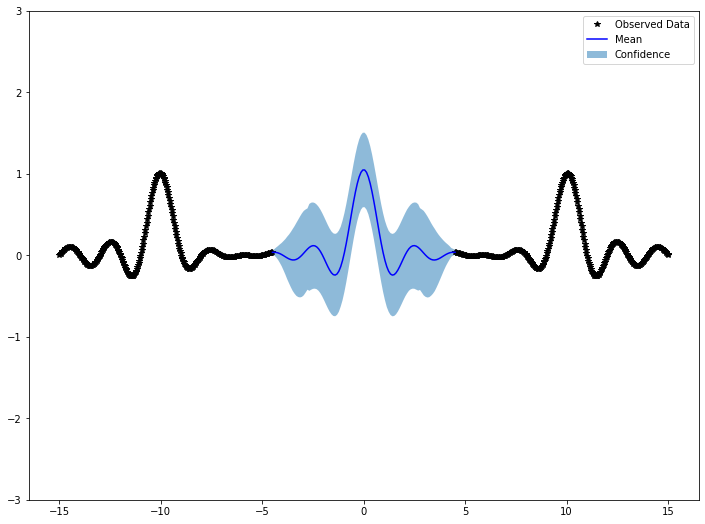

In [363]:
trained_model, trained_likelihood = train({}, True, 100, 43)
observed_pred = evaluate(trained_model, trained_likelihood)

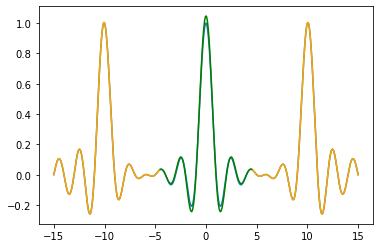

In [364]:
train_x1 = X[X<=-4.5]
train_x2 = X[X>=4.5]
plt.plot(X.cpu(), objective(X).cpu())
plt.plot(train_x1.cpu(), objective(train_x1).cpu(), 'orange')
plt.plot(train_x2.cpu(), objective(train_x2).cpu(), 'orange')
plt.plot(test_x.cpu(), observed_pred.mean.cpu().numpy(), 'green')

In [33]:
[print(p) for p in trained_model.named_parameters()]
print(len(list(trained_model.parameters())))

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-3.5887], requires_grad=True))
('covar_module.raw_mixture_weights', Parameter containing:
tensor([-6.6170, -6.6357, -6.5232, -6.6435, -6.6885, -6.6943, -6.6321],
       requires_grad=True))
('covar_module.raw_mixture_means', Parameter containing:
tensor([[[-4.1851]],

        [[-2.2720]],

        [[-1.3984]],

        [[-1.0896]],

        [[-1.1048]],

        [[-0.6518]],

        [[-0.6737]]], requires_grad=True))
('covar_module.raw_mixture_scales', Parameter containing:
tensor([[[-5.4393]],

        [[-5.6557]],

        [[-5.4333]],

        [[-5.5524]],

        [[-5.5588]],

        [[-5.5124]],

        [[-5.2155]]], requires_grad=True))
4


In [44]:
trained_model.likelihood.noise

tensor([0.0002], grad_fn=<AddBackward0>)

In [1087]:
trained_model.covar_module.mixture_weights

tensor([0.1262, 0.1379, 0.1191, 0.1208, 0.1329, 0.1311, 0.1102],
       grad_fn=<SoftplusBackward>)

In [1088]:
trained_model.covar_module.mixture_means

tensor([[[0.0030]],

        [[0.1000]],

        [[0.2005]],

        [[0.2981]],

        [[0.4162]],

        [[0.4245]],

        [[0.4867]]], grad_fn=<SoftplusBackward>)

In [1089]:
trained_model.covar_module.mixture_scales

tensor([[[0.0565]],

        [[0.0458]],

        [[0.0512]],

        [[0.0521]],

        [[0.0350]],

        [[0.0329]],

        [[0.0177]]], grad_fn=<SoftplusBackward>)

In [1090]:
trained_model.covar_module.raw_mixture_scales

Parameter containing:
tensor([[[-2.8455]],

        [[-3.0600]],

        [[-2.9468]],

        [[-2.9282]],

        [[-3.3334]],

        [[-3.3991]],

        [[-4.0243]]], requires_grad=True)

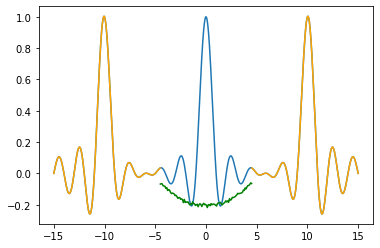

In [80]:
def discovery_loop(train_x, train_y, test_x, training_iter=100):
    torch.cuda.empty_cache()
    gc.collect()
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = SpectralMixtureGPModel(train_x, train_y, likelihood).cuda()

    # Get model and likelihood into training mode
    model.train()
    likelihood.train()
    
    # Use AdamW optimizer to train hyperparameters (don't see a pytorch implementation of nl-cg so I'm going with this)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=.1, amsgrad=True) #KINDA GOOD, SUPER FAST
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=100)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=.05)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100)
#     optimizer = torch.optim.SGD(model.parameters(), lr=.1, momentum=.9)
    # Marginal log likelihood as loss for training the hyperparameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
#     botorch.optim.fit.fit_gpytorch_torch(mll, options={'maxiter': 500})
    # Train hyperparameters
    """
    Pytorch training loop:
    1. Zero all parameter gradients
    2. Call the model and compute the loss
    3. Call backward on the loss to fill in gradients
    4. Take a step on the optimizer
    """
#     for i in range(training_iter):
#         clear_output(wait=True) # for outputting training progress
#         optimizer.zero_grad() # Clears the gradients of all optimized tensors
#         output = model(train_x)
#         loss = -mll(output, train_y)
#         loss.backward()
#         display('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
#         optimizer.step()    
        
        
    for i in range(training_iter):
        clear_output(wait=True)
        def closure():
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            display('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
            return loss
        optimizer.step(closure)
        scheduler.step()

#     def marglog(hyps, xtrn, ytrn, mshape, wshape):
#         mten = torch.tensor(hyps[:10].reshape(mshape)).float() + 1.000e-4
#         wten = torch.abs(torch.tensor(hyps[10:20].reshape(wshape)).float()) + 1.000e-4
#         gpmten = torch.nn.Parameter(torch.tensor(hyps[20:21]).float())
#         noise = torch.abs(torch.tensor(hyps[21]))
#         if noise < 1.000e-04:
#             noise = 1.000e-4
        

#         likelihood.noise = noise
#         mdl = SpectralMixtureGPModel(train_x, train_y, likelihood, (gpmten, wten, mten))
#         ml = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, mdl)

        
#         out = mdl(xtrn)
#         loss = -ml(out, ytrn)
#         loss.backward()
# #         print(loss.item())
#         return loss.item()
    
#     means = model.covar_module.mixture_means
#     weights = model.covar_module.mixture_weights
#     meanshape = means.shape
#     weightshape = weights.shape
#     gpmean = model.mean_module.constant
#     liknoise = likelihood.noise
    
#     wnp = weights.detach().cpu().numpy()
#     mnp = means.detach().cpu().numpy().flatten()
#     gpmnp = gpmean.detach().cpu().numpy()
#     lnnp = liknoise.detach().cpu().numpy()
#     comb = np.concatenate([mnp, wnp, gpmnp, lnnp])
    
#     optArgs = (train_x, train_y, meanshape, weightshape)
    
#     optHyps = optimize.fmin_cg(marglog, comb, args=optArgs, epsilon=0.1, maxiter=2*(200*len(comb)))

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        # Make predictions
        observed_pred = likelihood(model(test_x))

        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(12, 9))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        
        return model, likelihood, observed_pred

'Iter 19/19 - Loss: 1.353'

'Iter 19/19 - Loss: 1.353'

'Iter 19/19 - Loss: 1.352'

'Iter 19/19 - Loss: 1.352'

'Iter 19/19 - Loss: 1.351'

'Iter 19/19 - Loss: 1.351'

'Iter 19/19 - Loss: 1.350'

'Iter 19/19 - Loss: 1.350'

'Iter 19/19 - Loss: 1.349'

'Iter 19/19 - Loss: 1.349'

'Iter 19/19 - Loss: 1.349'

'Iter 19/19 - Loss: 1.348'

'Iter 19/19 - Loss: 1.348'

'Iter 19/19 - Loss: 1.347'

'Iter 19/19 - Loss: 1.347'

'Iter 19/19 - Loss: 1.346'

'Iter 19/19 - Loss: 1.346'

'Iter 19/19 - Loss: 1.345'

'Iter 19/19 - Loss: 1.345'

'Iter 19/19 - Loss: 1.344'

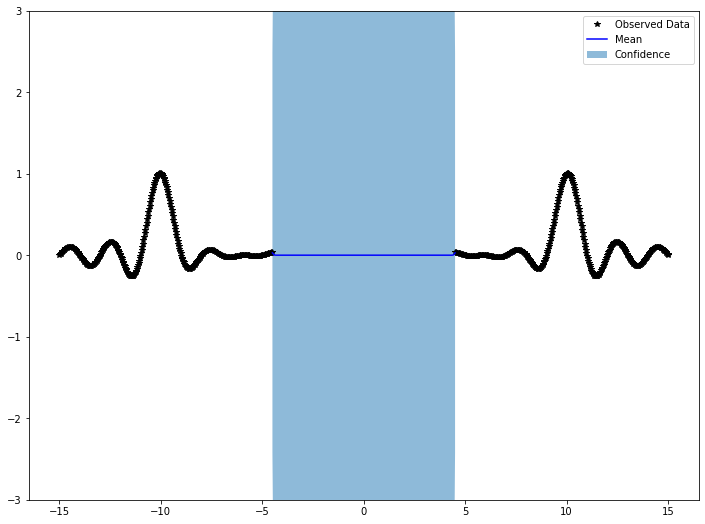

In [81]:
torch.no_grad()

trained_model, trained_likelihood, observed_pred = discovery_loop(train_x, train_y, test_x, 19)

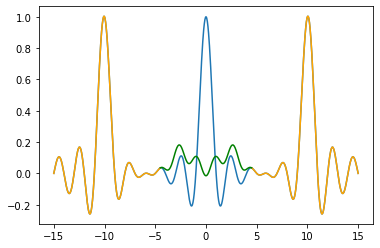

In [318]:
train_x1 = X[X<=-4.5]
train_x2 = X[X>=4.5]
plt.plot(X.cpu(), objective(X).cpu())
plt.plot(train_x1.cpu(), objective(train_x1).cpu(), 'orange')
plt.plot(train_x2.cpu(), objective(train_x2).cpu(), 'orange')
plt.plot(test_x.cpu(), observed_pred.mean.cpu().numpy(), 'green')

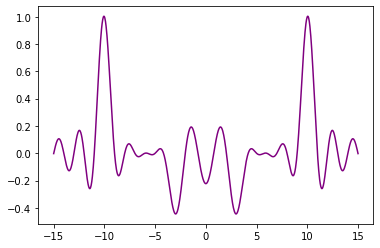

In [9]:
all_pred = trained_likelihood(trained_model(X))
plt.plot(X.cpu().numpy(), all_pred.mean.detach().cpu().numpy(), 'purple')

In [140]:
trained_model.covar_module.mixture_weights

tensor([0., 0., 0., 0., 0., 0., 0.], grad_fn=<SoftplusBackward>)

In [141]:
trained_model.covar_module.mixture_means

tensor([[[0.0300]],

        [[0.1000]],

        [[0.2000]],

        [[0.3000]],

        [[0.4150]],

        [[0.4240]],

        [[0.4920]]], grad_fn=<AddBackward0>)

In [142]:
trained_model.covar_module.mixture_scales

tensor([[[-2.9957]],

        [[-2.9957]],

        [[-2.9957]],

        [[-2.9957]],

        [[-2.9957]],

        [[-2.9957]],

        [[-2.9957]]], grad_fn=<AddBackward0>)

In [86]:
#0.03; 0.1; 0.2; 0.3; 0.415; 0.424; 0.492
torch.log(torch.tensor([[[.03]], [[.1]], [[.2]], [[.3]], [[.415]], [[.424]], [[.492]]])).size()

torch.Size([7, 1, 1])

In [87]:
torch.ones(7).reshape((7,1,1))

tensor([[[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]]])

In [15]:
trained_model.parameters

<bound method Module.parameters of SpectralMixtureGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): SpectralMixtureKernel(
    (raw_mixture_scales_constraint): Positive()
    (raw_mixture_means_constraint): Positive()
    (raw_mixture_weights_constraint): Positive()
  )
)>

In [120]:
torch.normal(0.0, 0.8300055911565357, size=(1,Q))[0].reshape((Q,1,1))

tensor([[[-0.2693]],

        [[-0.0167]],

        [[ 1.2257]],

        [[-0.5695]],

        [[ 0.0774]],

        [[-0.0869]],

        [[-0.8027]]])

In [123]:
torch.log(torch.ones(Q))

tensor([0., 0., 0., 0., 0., 0., 0.])